# Final Model for MFCCs 

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import math
import librosa
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import json
from pandas.io.json import json_normalize
%matplotlib inline


First, I need to extract the audio's MFCCs. I am aware of how limited my dataset is. I want to increase the size of my dataset. Consequently, I divided the audio into 13 segments. This will increase my dataset and allow for greater accuracy. I have skipped over one audio file in the dataset because it was corrupted when I downloaded it. Once the mfccs have been extracted, it will be saved in a JSON file. 


In [2]:

DATASET_PATH = "data/genres_original"
JSON_PATH = "mfccs(song_split_into_13parts).json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.
        :dataset_path (str): Path to dataset
        :json_path (str): Path to json file used to save MFCCs
        :num_mfcc (int): Number of coefficients to extract
        :n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :hop_length (int): Sliding window for FFT. Measured in # of samples
        : num_segments (int): Number of segments we want to divide sample tracks into
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

 
        if dirpath is not dataset_path and dirpath != '.DS_Store': # for mac users, there will be an extra file called .DS_Store 


            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            for f in filenames:

    # load audio file
                file_path = os.path.join(dirpath, f)
                if file_path  != 'data/genres_original/jazz/jazz.00054.wav':
                    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                   
                    for d in range(num_segments):

                     
                        start = samples_per_segment * d
                        finish = start + samples_per_segment

 
                        mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                        mfcc = mfcc.T


                        if len(mfcc) == num_mfcc_vectors_per_segment:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
   

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
        
        
# reference 1: https://towardsdatascience.com/music-genre-detection-with-deep-learning-cf89e4cb2ecc (Marc Saint Felix,2021)
# reference 2: https://www.kaggle.com/code/tarushijat/music-genre-classification-using-cnn ( Bryan Choo , 2020)

In [3]:
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=13)


Processing: pop

Processing: metal

Processing: disco

Processing: blues

Processing: reggae

Processing: classical

Processing: rock

Processing: hiphop

Processing: country

Processing: jazz


Once all the MFCCs are all saved in the JSON file, I will then extract the information from the file and assign them accordingly. X = MFCCs features y = label(genre of the audio)

In [3]:
def load_data(data_path):
    
    with open(data_path, "r") as fp:
        data = json.load(fp)
    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")
    
    return X,y


In [4]:
X,y = load_data('./mfccs(song_split_into_13parts).json')

# X_norm = data_normalization(X)
# X_norm = X_norm[...,np.newaxis]

X = X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
y = tf.keras.utils.to_categorical(y , num_classes =10)

print('X' , X.shape)
print('y' , y.shape)

 # (num_samples,130,13,1)
 

Data succesfully loaded!
X (12985, 100, 13, 1)
y (12985, 10)


Once the information has been successfully loaded, it is time to split the dataset. 

80% training set 
20% test set 

Within the training set, 
20% would be for the validation set. 

When training the model, the model will be trained using the partial training set and will be evaluated against the validation set. Once i am satisfied with the validation accuracy, i will then train the whole trainign set and then evaluate against the test set. 

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2)
print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('Y_train',Y_train.shape)
print('Y_test',Y_test.shape)
print('______________')
print('x_train',x_train.shape)
print('x_val',x_val.shape)
print('y_train',y_train.shape)
print('y_val',y_val.shape)

X_train (10388, 100, 13, 1)
X_test (2597, 100, 13, 1)
Y_train (10388, 10)
Y_test (2597, 10)
______________
x_train (8310, 100, 13, 1)
x_val (2078, 100, 13, 1)
y_train (8310, 10)
y_val (2078, 10)


In [6]:
x_train.shape

(8310, 100, 13, 1)

In [7]:
# input_shape = (x_train.shape[1],x_train.shape[2],1)
# input_shape
input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])
input_shape

(100, 13, 1)

This is the helper code when i want to plot the validation accuracy / loss graph. 

In [8]:
def plot_metric(history, metric):
    train_metrics = history.history[metric] #take the history of the model
    val_metrics = history.history['val_'+metric] #what meteric i want to plot 
    epochs = range(1, len(train_metrics) + 1)# plot against the epochs 
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric) # title of the graph 
    plt.xlabel("Epochs") #label for the x label 
    plt.ylabel(metric) #label for the y label
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

# CNN

I would first build the first model and then take the validation accuracy as my base model. Using the categoroical loss function , the adam optimizer and a stop early callback to prevent overfitting, the model achieve an validation accuracy of 70.6%

In [13]:
import tensorflow.keras as keras


def build_model(input_shape):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(32 , (3,3) ,activation = 'relu', input_shape=input_shape,kernel_regularizer =tf.keras.regularizers.l2( l=0.001)))
    model.add(keras.layers.MaxPooling2D((3,3),strides=(2,2),padding='same'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(128 , (3,3) ,activation = 'relu',kernel_regularizer =tf.keras.regularizers.l2( l=0.001)))
    model.add(keras.layers.MaxPooling2D((3,3),strides=(2,2),padding='same'))
    model.add(keras.layers.BatchNormalization())

    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128,activation = 'relu',kernel_regularizer =tf.keras.regularizers.l2( l=0.001)))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(10,activation='softmax'))
    
    return model

In [14]:
input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])
model = build_model(input_shape)
optimizer =  keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = optimizer ,loss = 'categorical_crossentropy',metrics=['accuracy'])

In [15]:
tf.random.set_seed(3) 
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(x_train,y_train,validation_data=(x_val,y_val),batch_size=32,epochs=30,callbacks=[stop_early])

Epoch 1/30
260/260 [==============================] - 12s 42ms/step - loss: 1.9093 - accuracy: 0.4463 - val_loss: 1.6122 - val_accuracy: 0.5072
Epoch 2/30
260/260 [==============================] - 11s 41ms/step - loss: 1.5450 - accuracy: 0.5449 - val_loss: 1.3469 - val_accuracy: 0.6150
Epoch 3/30
260/260 [==============================] - 10s 40ms/step - loss: 1.3875 - accuracy: 0.5964 - val_loss: 1.2982 - val_accuracy: 0.6415
Epoch 4/30
260/260 [==============================] - 10s 40ms/step - loss: 1.2793 - accuracy: 0.6401 - val_loss: 1.3149 - val_accuracy: 0.6429
Epoch 5/30
260/260 [==============================] - 11s 43ms/step - loss: 1.1664 - accuracy: 0.6915 - val_loss: 1.2200 - val_accuracy: 0.7002
Epoch 6/30
260/260 [==============================] - 10s 40ms/step - loss: 1.1276 - accuracy: 0.7172 - val_loss: 1.2629 - val_accuracy: 0.6910
Epoch 7/30
260/260 [==============================] - 11s 40ms/step - loss: 1.0490 - accuracy: 0.7614 - val_loss: 1.4905 - val_accuracy:

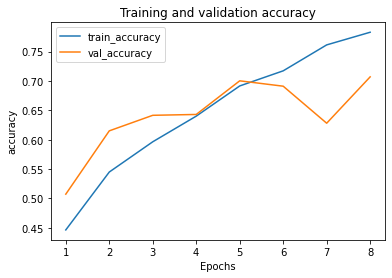

In [16]:
plot_metric(history,'accuracy')

Setting 70.6% as the base accuracy, we can continue use the keras tuner to help us do the hyperparameter tuning. I first build the hypermodel architect and each of the layers, i would include a range of neurons for the tuner to search, including the dropout layer neurons. I would also add l2 regularizers at each of the layers to prevent overfitting. To top it off, I have also added a choice where the tuner would need to choose the learning rate of the adam optimizer. As for the loss function, it would remain the same as the base model.

#### Architect 1

In [10]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D( filters=hp.Int('conv_1_filter', min_value=16, max_value=128, step=16) ,
                                  kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
                                  activation = 'relu', 
                                  input_shape=input_shape,
                                  kernel_regularizer =tf.keras.regularizers.l2( l=0.001)))
    model.add(keras.layers.MaxPooling2D((3,3),strides=(2,2),padding='same'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
                                  kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
                                  activation = 'relu',
                                  kernel_regularizer =tf.keras.regularizers.l2( l=0.001)))
    model.add(keras.layers.MaxPooling2D((3,3),strides=(2,2),padding='same'))
    model.add(keras.layers.BatchNormalization())

    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
                                 activation = 'relu',
                                 kernel_regularizer =tf.keras.regularizers.l2( l=0.001)))
    model.add(keras.layers.Dropout(hp.Float('dropout_2',min_value=0.0,max_value=0.5,default=0.25,step=0.05)))
    model.add(keras.layers.Dense(10,activation='softmax'))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [11]:
import kerastuner as kt
tuner = kt.Hyperband(build_model, # the hypermodel
                     objective='val_accuracy', # objective to optimize
max_epochs=30,
factor=3, # factor which you have seen above 
directory='CNN_2D_A1/', # directory to save logs 
project_name='FYP_model')

INFO:tensorflow:Reloading Oracle from existing project CNN_2D_A1/FYP_model/oracle.json


/var/folders/22/qly4z7kd12j_7539lt57vw_00000gn/T/ipykernel_1776/893604305.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt
2022-08-22 23:06:06.663152: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Reloading Tuner from CNN_2D_A1/FYP_model/tuner0.json


In [12]:
tuner.search_space_summary() 

Search space summary
Default search space size: 7
conv_1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_2_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dense_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
dropout_2 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [20]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) 
# Perform hypertuning
tuner.search(x_train, y_train, epochs=30, validation_data=(x_val,y_val), batch_size = 32, callbacks=[stop_early])

Trial 90 Complete [00h 02m 08s]
val_accuracy: 0.5187680721282959

Best val_accuracy So Far: 0.7699711322784424
Total elapsed time: 01h 49m 23s
INFO:tensorflow:Oracle triggered exit


After a number of trials, we can see the best validation accuracy that the tuner managed to achieve 76.9%.  With this, i take the best hyperparameter and build another validation model with a stop early callback to prevent overfitting. However, it stopped at epoch 13 as the stop early callback is activated when the validation loss dosent improve after 3 epochs.

In [13]:
best_hp = tuner.get_best_hyperparameters()[0]
best_hp.values

{'conv_1_filter': 112,
 'conv_1_kernel': 5,
 'conv_2_filter': 112,
 'conv_2_kernel': 5,
 'dense_1_units': 64,
 'dropout_2': 0.35000000000000003,
 'learning_rate': 0.0001,
 'tuner/epochs': 30,
 'tuner/initial_epoch': 10,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0068'}

In [15]:
h_model = tuner.hypermodel.build(best_hp)
h_model.summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) 
tf.random.set_seed(3) 
h_model_history = h_model.fit(x_train, y_train, epochs=30, validation_data = (x_val,y_val), batch_size = 32, callbacks=[stop_early])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 96, 9, 112)        2912      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 5, 112)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 48, 5, 112)       448       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 44, 1, 112)        313712    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 22, 1, 112)       0         
 2D)                                                             
                                                      

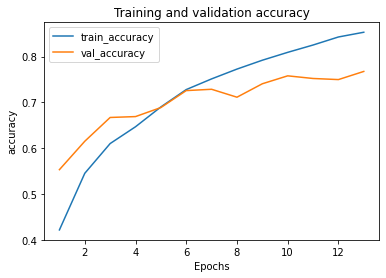

In [17]:
plot_metric(h_model_history,'accuracy')

After that, we built a model using the best hyperparameter to train the entire training set and compare it to the test set. Since the model starts to stabilize at epoch 10, I chose to use that value. Consequently, the model was trained using the optimal hyperparameter combination and 10 iterations, yielding an accuracy of 77.32%.


In [18]:
hypermodel = tuner.hypermodel.build(best_hp)
tf.random.set_seed(3) 
# Retrain the modelii
h_model_history_with_best_epochs = hypermodel.fit(X_train, Y_train, epochs=10, validation_data = (X_test,Y_test), batch_size = 32, callbacks=[stop_early])

Epoch 1/10
325/325 [==============================] - 21s 62ms/step - loss: 1.9475 - accuracy: 0.4286 - val_loss: 1.5282 - val_accuracy: 0.5375
Epoch 2/10
325/325 [==============================] - 19s 60ms/step - loss: 1.4863 - accuracy: 0.5657 - val_loss: 1.2714 - val_accuracy: 0.6515
Epoch 3/10
325/325 [==============================] - 20s 60ms/step - loss: 1.3130 - accuracy: 0.6264 - val_loss: 1.2184 - val_accuracy: 0.6623
Epoch 4/10
325/325 [==============================] - 20s 61ms/step - loss: 1.1773 - accuracy: 0.6771 - val_loss: 1.1749 - val_accuracy: 0.6692
Epoch 5/10
325/325 [==============================] - 21s 65ms/step - loss: 1.0680 - accuracy: 0.7107 - val_loss: 1.0867 - val_accuracy: 0.7023
Epoch 6/10
325/325 [==============================] - 26s 81ms/step - loss: 0.9868 - accuracy: 0.7424 - val_loss: 1.0120 - val_accuracy: 0.7297
Epoch 7/10
325/325 [==============================] - 23s 72ms/step - loss: 0.9202 - accuracy: 0.7611 - val_loss: 0.9812 - val_accuracy:

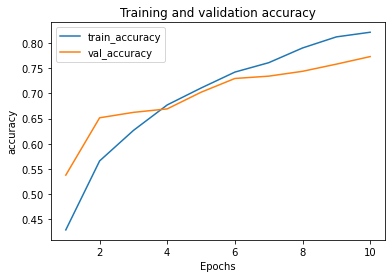

In [19]:
plot_metric(h_model_history_with_best_epochs,'accuracy')

In [20]:
test_loss, test_accuracy= hypermodel.evaluate(X_test,Y_test)
test_accuracy*100

82/82 [==============================] - 2s 20ms/step - loss: 0.9035 - accuracy: 0.7732


77.31998562812805

I don't think the accuracy has much room for improvement given the 77.32% accuracy yield. For this reason, I modified the hyper model architecture to include a drop-out layer and l1_ l2 regularization at the layers, as well as to increase the neuron  range in the layer. As soon as the hypermodel architect was changed from the previous hypermodel architect, the best validation accuracy increased from the previous tuner search from 76.9% to 82.3%, as can be seen.

#### Architect 2 ( With dropout and l1_l2 regularization) 

In [9]:
import tensorflow.keras as keras

def build_model_A2(hp):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D( filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16) ,
                                  kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
                                  activation = 'relu', 
                                  input_shape=input_shape,
                                  kernel_regularizer=tf.keras.regularizers.l1_l2(hp.Choice('rate', values=[1e-2, 1e-3,1e-4]))))
    model.add(keras.layers.MaxPooling2D((3,3),strides=(2,2),padding='same'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(filters=hp.Int('conv_2_filter', min_value=128, max_value=256, step=16),
                                  kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
                                  activation = 'relu',
                                   kernel_regularizer=tf.keras.regularizers.l1_l2(hp.Choice('rate', values=[1e-2, 1e-3,1e-4]))))
    model.add(keras.layers.MaxPooling2D((3,3),strides=(2,2),padding='same'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Flatten())
    for i in range(hp.Int('n_connections', 1, 3)):
        model.add(keras.layers.Dense(units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
                                 activation = 'relu',
                                 kernel_regularizer=tf.keras.regularizers.l1_l2(hp.Choice('rate', values=[1e-2, 1e-3,1e-4]))))

    model.add(keras.layers.Dropout(hp.Float('dropout_2',min_value=0.0,max_value=0.5,default=0.25,step=0.05)))
    model.add(keras.layers.Dense(10,activation='softmax'))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model
# CNN --> discover the features, performed better than enginnered features 
# comment why cannot get it better 

In [10]:
import kerastuner as kt
tuner = kt.Hyperband(build_model_A2, # the hypermodel
                     objective='val_accuracy', # objective to optimize
max_epochs=30,
factor=3, # factor which you have seen above 
directory='CNN_2D_A2/', # directory to save logs 
project_name='FYP_model')

INFO:tensorflow:Reloading Oracle from existing project CNN_2D_A2/FYP_model/oracle.json


/var/folders/22/qly4z7kd12j_7539lt57vw_00000gn/T/ipykernel_9762/379051079.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt
2022-08-25 21:04:15.537495: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Reloading Tuner from CNN_2D_A2/FYP_model/tuner0.json


In [11]:
tuner.search_space_summary() 

Search space summary
Default search space size: 9
conv_1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
conv_2_filter (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 16, 'sampling': None}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
n_connections (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
dense_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
dropout_2 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'value

In [67]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(x_train,y_train,epochs=30,validation_data=(x_val,y_val),batch_size = 32, callbacks=[stop_early])


Trial 90 Complete [00h 17m 04s]
val_accuracy: 0.8075072169303894

Best val_accuracy So Far: 0.8238691091537476
Total elapsed time: 03h 09m 56s
INFO:tensorflow:Oracle triggered exit


In [12]:
best_hp_2 = tuner.get_best_hyperparameters()[0]
best_hp_2.values

{'conv_1_filter': 128,
 'conv_1_kernel': 5,
 'rate': 0.0001,
 'conv_2_filter': 160,
 'conv_2_kernel': 5,
 'n_connections': 3,
 'dense_1_units': 128,
 'dropout_2': 0.1,
 'learning_rate': 0.0001,
 'tuner/epochs': 30,
 'tuner/initial_epoch': 10,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0067'}

Using the best hyperparameter combination along with a stop early callback and a model checkpoint callback, I rebuilt the model. The model checkpoint allows me to determine whether the validation loss has decreased since the previous epoch, and if so, the model is saved as the best one since it has the lowest validation loss. As a result, I was able to validate data with an acceptable accuracy of 82.7%.


In [46]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
h_model_2 = tuner.hypermodel.build(best_hp_2)
h_model_2.summary()
tf.random.set_seed(3) 
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
filepath = 'my_best_model_MFCCs.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [stop_early,checkpoint]
h_model_2_history = h_model_2.fit(x_train, y_train, epochs=30, validation_data = (x_val,y_val), batch_size = 32, callbacks=callbacks)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 96, 9, 128)        3328      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 48, 5, 128)       0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 48, 5, 128)       512       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 44, 1, 160)        512160    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 22, 1, 160)       0         
 2D)                                                             
                                                      

260/260 [==============================] - 25s 98ms/step - loss: 1.1776 - accuracy: 0.9653 - val_loss: 1.6003 - val_accuracy: 0.7926
Epoch 20/30
260/260 [==============================] - ETA: 0s - loss: 1.1179 - accuracy: 0.9663
Epoch 20: val_loss improved from 1.60033 to 1.49579, saving model to my_best_model_MFCCs.hdf5
260/260 [==============================] - 24s 91ms/step - loss: 1.1179 - accuracy: 0.9663 - val_loss: 1.4958 - val_accuracy: 0.8138
Epoch 21/30
260/260 [==============================] - ETA: 0s - loss: 1.0529 - accuracy: 0.9680
Epoch 21: val_loss improved from 1.49579 to 1.45958, saving model to my_best_model_MFCCs.hdf5
260/260 [==============================] - 24s 93ms/step - loss: 1.0529 - accuracy: 0.9680 - val_loss: 1.4596 - val_accuracy: 0.8013
Epoch 22/30
260/260 [==============================] - ETA: 0s - loss: 1.0202 - accuracy: 0.9600
Epoch 22: val_loss did not improve from 1.45958
260/260 [==============================] - 24s 92ms/step - loss: 1.0202 - 

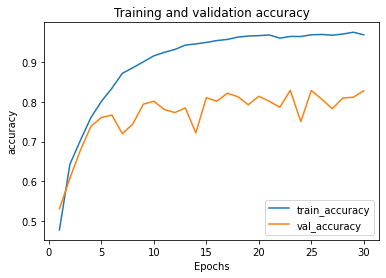

In [48]:
plot_metric(h_model_2_history,'accuracy')

Considering that the best model was saved and the validation accuracy was satisfactory. They were trained using the entire training set after I loaded the saved model. Since the model was stable at epoch 5, I chose to train the entire training set over 5 epochs and evaluate the results to the test set. This led to me having an 81.6% test accuracy.

In [51]:
tf.random.set_seed(3) 
final_model = load_model(filepath)
h_model_2_history_with_best_epochs = final_model.fit(X_train, Y_train, epochs=5, validation_data = (X_test,Y_test), batch_size = 32, callbacks=[stop_early])

Epoch 1/5
325/325 [==============================] - 29s 88ms/step - loss: 0.8890 - accuracy: 0.9171 - val_loss: 1.3938 - val_accuracy: 0.7536
Epoch 2/5
325/325 [==============================] - 28s 86ms/step - loss: 0.8061 - accuracy: 0.9451 - val_loss: 1.1479 - val_accuracy: 0.8156
Epoch 3/5
325/325 [==============================] - 29s 88ms/step - loss: 0.7274 - accuracy: 0.9649 - val_loss: 1.0975 - val_accuracy: 0.8375
Epoch 4/5
325/325 [==============================] - 28s 87ms/step - loss: 0.6944 - accuracy: 0.9696 - val_loss: 1.2330 - val_accuracy: 0.7851
Epoch 5/5
325/325 [==============================] - 28s 87ms/step - loss: 0.6868 - accuracy: 0.9671 - val_loss: 1.1303 - val_accuracy: 0.8163


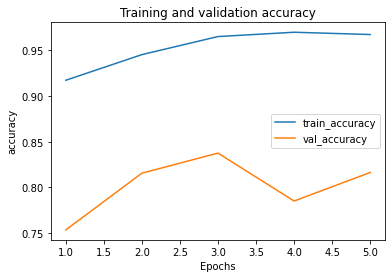

In [54]:
plot_metric(h_model_2_history_with_best_epochs,'accuracy')

In [55]:
test_loss,test_accuracy = final_model.evaluate(X_test,Y_test)
print('test accuracy fro second model', test_accuracy*100)

82/82 [==============================] - 2s 26ms/step - loss: 1.1303 - accuracy: 0.8163
test accuracy fro second model 81.63265585899353



As can be seen, the test accuracy has significantly increased from the previous model (77.3%). I'll use this model as my 2D CNN final model as a result. Below is the classification report of the model. The precision, recall, and f1 score are all within an average of 82%, as can be seen, which is a good sign. 


In [56]:
from sklearn.metrics import classification_report

# predict 
y_pred = final_model.predict(X_test, batch_size = 32)
y_pred = np.argmax(y_pred, axis=1)
# label
y_ground_truth = np.argmax(Y_test, axis=1)

print(classification_report(y_ground_truth, y_pred))

82/82 [==============================] - 2s 24ms/step
              precision    recall  f1-score   support

           0       0.90      0.79      0.84       234
           1       0.87      0.91      0.89       284
           2       0.72      0.93      0.81       250
           3       0.92      0.76      0.83       259
           4       0.87      0.80      0.83       274
           5       0.86      0.99      0.92       250
           6       0.76      0.54      0.63       275
           7       0.98      0.69      0.81       263
           8       0.60      0.90      0.72       261
           9       0.88      0.86      0.87       247

    accuracy                           0.82      2597
   macro avg       0.84      0.82      0.82      2597
weighted avg       0.83      0.82      0.82      2597



However, it doesnt beat the accuracy of the other 3 models ( KNN, SVM and the Sequential Model), which has an average of 90%. Hence, i will be taking SVM as my final model as it has the highest test accuracy. 

___________________